In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import higher

In [4]:
a = torch.tensor([1,2,3])
b = torch.tensor([0,3,1])
c = torch.maximum(a,b)
c

tensor([1, 3, 3])

In [149]:
seq_len_global = 5

In [180]:

def make_toy_data(num_examples, inpt_func, outpt_func):
    generator =  torch.rand(num_examples)
    inpt = inpt_func(generator)
    outpt = outpt_func(inpt)
    return inpt, outpt

def check_outpt(label, outpt, tol_neg, tol_pos):
    diff = label-outpt
    neg_acc = diff > tol_neg[None,None,:]
    pos_acc = diff < tol_pos[None,None,:]
    acc = neg_acc*pos_acc
    acc = acc.reshape(diff.size(0), -1)
    return torch.all(acc, dim=1)

def make_tol(std_dev, dim, add=1e-3, device = 'cpu'):
    tol_neg = - (torch.abs(torch.normal(mean=torch.zeros(dim), std=std_dev*torch.ones(dim))) + add).to(device)
    tol_pos = + (torch.abs(torch.normal(mean=torch.zeros(dim), std=std_dev*torch.ones(dim))) + add).to(device)
    return tol_neg, tol_pos

def make_func(dim_in,dim_out, seq_len):
    seq_add = torch.arange(0,1,1/seq_len)
    '''    di_a = [[i for i in range(dim_in)] for j in range(dim_in)]
    print('asdsd')
    index_ = list(itertools.product(*di_a))
    print(len(index_))
    ri = random.choices(index_, k=dim_out)
    tri = torch.tensor(ri)'''
    tri = torch.randint(low=0, high=dim_in, size=(dim_out, dim_in))
    print(tri)
    signs = torch.randint(low=-1, high=2, size=(dim_in*dim_out,)).reshape(dim_out, dim_in)
    #print(signs)

    tri = tri.reshape(-1).repeat(seq_len).reshape(1,-1)
    seq_counter = torch.arange(0, seq_len).reshape(1,-1).repeat([dim_in*dim_out, 1]).T.reshape(1,-1)
    tri = torch.cat((seq_counter, tri), dim=0)
    def inner_fc(inpt):
        n = len(inpt)
        tri_n = tri.repeat([1, n])
        n_counter = torch.arange(0, n).reshape(1,-1).repeat([dim_in*dim_out*seq_len, 1]).T.reshape(1,-1)
        tri_n = torch.cat((n_counter, tri_n), dim=0)
        seq_inpt = inpt[:,None, :] + seq_add[None,:,None]
        result = seq_inpt[tuple(tri_n)]
        result = result.reshape(n,seq_len, dim_out, dim_in)
        result = result*signs[None,None,:,:]
        result[(signs==0)[None,None,:,:].repeat([result.size(0), result.size(1),1,1])]=1
        result = torch.prod(result, dim=-1)
        return result
    return inner_fc

def plot_fcts(inpt, neg_tol, pos_tol):
    inpt_dim = len(inpt[0])
    neg_inpt = (inpt + neg_tol[None,:]).numpy()
    pos_inpt = (inpt + pos_tol[None,:]).numpy()
    seq_len = len(inpt)
    np_inpt = inpt.numpy()
    num_graphs = int(np.ceil(np.sqrt(inpt_dim)))
    fig, ax = plt.subplots(num_graphs,num_graphs)
    fig.set_size_inches(9, 9)
    for sp in range(inpt_dim):
        idx = sp // num_graphs
        idy = sp  % num_graphs
        ax[idx,idy].clear()
        ax[idx,idy].plot(range(seq_len), np_inpt[:,sp], alpha=0.5, color='midnightblue')
        ax[idx,idy].plot(range(seq_len), neg_inpt[:,sp], alpha=0.5, color='orangered')
        ax[idx,idy].plot(range(seq_len), pos_inpt[:,sp], alpha=0.5, color='orangered')

def save(path, dict):
    if not os.path.exists(path):
        os.makedirs(path)

    for dk, data in dict.items():
        tdata = data
        torch.save(tdata, path + str(dk))

def make_toy_data(fct, n, dim_in, std = 0.1):
    inpt = torch.normal(mean=torch.zeros([n,1, dim_in]), std=std*torch.ones([n,1,dim_in]))
    print('äöl')
    print(inpt.max())
    print(inpt.min())
    label = fct(inpt[:,0])
    tl = label.transpose(0,2)
    tl = tl.reshape([tl.size(0),-1])
    mean_label = tl.mean(dim=1)
    label = label - mean_label
    tl = label.transpose(0,2)
    tl = tl.reshape([tl.size(0),-1])
    tmax = tl[:10].max(dim=1)[0]
    tmin = tl[:10].min(dim=1)[0]
    #print(label.transpose(0,2).max(dim=0))
    rel_corr = tmax - tmin
    #print(rel_corr)
    #label = 2*(label / (rel_corr[None,None,:]))
    label = label % 1

    data_sets = ['train', 'val', 'test']
    for i, set in enumerate(data_sets):
        path = '/home/hendrik/Documents/master_project/LokalData/metaworld/test/toy_data/' + set + '/'
        start = i * int(len(inpt)/len(data_sets))
        end = (i+1) * int(len(inpt)/len(data_sets))
        print(start)
        print(end)
        save(path=path, dict={'inpt':5*inpt[start:end], 'label':label[start:end]})
    return inpt, label

In [185]:
inner_fct = make_func(dim_in=4, dim_out=4, seq_len=seq_len_global)


tensor([[1, 3, 1, 2],
        [0, 1, 2, 0],
        [0, 2, 2, 3],
        [1, 3, 0, 1]])


In [188]:
neg, pos = make_tol(std_dev=5e-1, dim=4, add=5e-2)


äöl
tensor(0.4400)
tensor(-0.4720)
0
10000
10000
20000
20000
30000


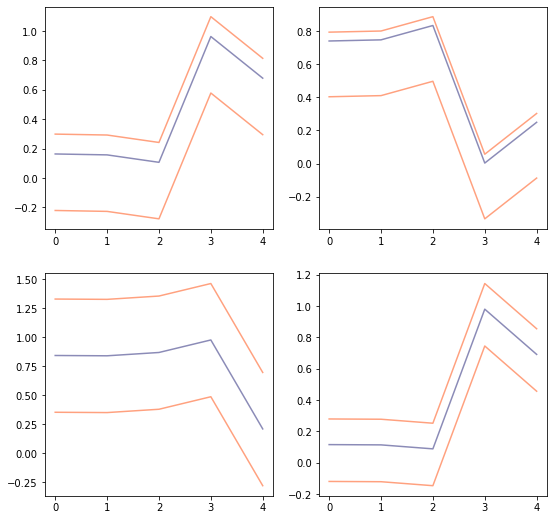

In [189]:
inpt, label = make_toy_data(inner_fct, n=30000, dim_in=4, std=0.1)
#print(inpt)
#print(inpt.shape)
outpt = torch.clone(label)
outpt[0,0,0] = 20
#print(check_outpt(label=inpt, outpt=outpt, tol_neg=neg, tol_pos=pos))
plot_fcts(inpt=label[0], neg_tol=neg, pos_tol=pos)
#make_func(2,3,torch.tensor([1,2]))

In [164]:
neg, pos = make_tol(std_dev=5e-1, dim=4, add=1e-3)


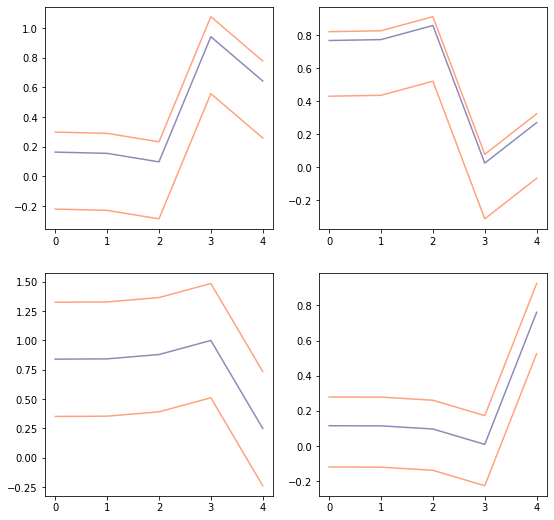

In [190]:
plot_fcts(inpt=label[14], neg_tol=neg, pos_tol=pos)


In [124]:
a = torch.arange(10)

In [125]:
a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [126]:
a = a.reshape(1,-1).repeat(4,1)

In [127]:
a

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [130]:
b = torch.tensor([0,1,3,4])
c = b + 3

In [131]:
c

tensor([3, 4, 6, 7])

In [132]:
a[tuple([0,0]):tuple([0,1])]

TypeError: slice indices must be integers or None or have an __index__ method